In [2]:
%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
)
from keras.datasets import mnist, fashion_mnist, cifar10, cifar100
from keras.layers import (
    Conv2D,
    Dense,
    Flatten,
    Input,
    MaxPooling2D,
    Reshape,
    UpSampling2D,
)
from keras.models import Model, Sequential, load_model
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix

In [3]:
#CIFAR_10 = cifar10.load_data()
#CIFAR_100 = cifar100.load_data()
#MNIST = mnist.load_data()
FASHION_MNIST = fashion_mnist.load_data()

In [4]:
# this is the size of our encoded representations
ENCODING_DIM = 10

# decision boundary for classifier
THRESHOLD = 0.7

# working directory
CUR_DIR = os.path.abspath(os.path.curdir)

# setting random seed for reproducable results
np.random.seed(42)

In [5]:
def train_test_split(X, y, train_split=0.7, test_split=0.85):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    # define boundaries for train,validation and test set at .7 and .85 % of the MNIST data set
    x_len = len(X)
    boundaries = [int(x_len * train_split), int(x_len * test_split)]

    [X_train, X_test, X_validate] = np.split(X, boundaries)

    [y_train, y_test, y_validate] = np.split(y, boundaries)
    return (X_train, X_test, X_validate), (y_train, y_test, y_validate)

In [6]:
def get_data(dataset, train_split=0.7, test_split=0.85):
    """retrieves data set and rebalances dataset, such that train=.7, test=.15 and validation=.15.
    :param dataset is assumed to be loaded from keras.datasets, thus the from 2-tuple(2-tuple) is assumed."""
    if not (len(dataset) == 2 and all([len(d) == 2 for d in dataset])):
        raise ValueError(
            "Datset has not the correct form. Please load from keras.datasets or convert to similar form."
        )

    (X_train, y_train), (X_test, y_test) = dataset
    if len(X_train.shape) == 3: # MNIST data set
        X_train = X_train.reshape((list(X_train.shape) + [1])) /255.0
        test_len = len(X_test)
        X_test = X_test.reshape((list(X_test.shape) + [1])) / 255.0

    # divide X values bei 255.0 since MNIST data set changed such that pixel values are in [0,255]
    X = np.concatenate((X_train, X_test)) 
    y = np.concatenate((y_train, y_test))

    (X_train, X_test, X_validate), (y_train, y_test, y_validate) = train_test_split(
        X, y
    )  # default: .7, .85
    # one-hot encode target columns
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    y_validate = to_categorical(y_validate)

    return (X_train, X_test, X_validate), (y_train, y_test, y_validate)

In [7]:
(X_train, X_test, X_validate), (y_train, y_test, y_validate) = get_data(FASHION_MNIST)
#plt.imshow(X_train[3].reshape((28,28)),cmap="gray")

In [8]:
X_train.shape

(49000, 28, 28, 1)

In [9]:
def get_specific_data_set(X, y, fashion):
    # parameters are training AND test data for X respectively y
    # is assumed to be in one-hot-encoding
    y = np.argmax(y, axis=1)
    indices = np.where(y == fashion)

    # filtering by the passed fashion. needs to be an int
    X_fashion = X[indices]
    y_fashion = y[indices]

    y_fashion = to_categorical(y_fashion)  # array of length 2 of form [0., 1.]

    # splitting into training and test set is not necessary since the data for single fashions
    # is just used for evaluation purposes (except for "1")

    return [X_fashion, y_fashion]

In [10]:
X = np.concatenate((X_train, X_test, X_validate))
y = np.concatenate((y_train, y_test, y_validate))
X.shape, y.shape

((70000, 28, 28, 1), (70000, 10))

In [11]:
# fashion = 0
# X_zero, y_zero = get_specific_data_set(X, y, fashion)
# fashion = 8
# X_eight, y_eight = get_specific_data_set(X, y, fashion)
# fashion = 1
# X_one, y_one =  get_specific_data_set(X, y, fashion)
# fashion = 7
# X_seven, y_seven = get_specific_data_set(X, y, fashion)
fashion_data = [get_specific_data_set(X, y, i) for i in range(10)]

all_fashions = X[np.where(np.argmax(y,axis=1)!= 1)]

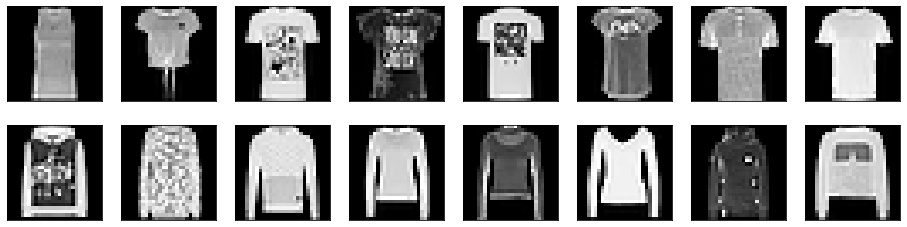

In [12]:
plt.figure(figsize=(16, 4))
for i in range(len(fashion_data[1][0][0]))[:8]:
    ax = plt.subplot(2, 8, i+1)
    plt.imshow(fashion_data[0][0][i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
for i in range(len(fashion_data[1][0][0]))[:8]:
    ax = plt.subplot(2, 8, 8+i+1)
    plt.imshow(fashion_data[2][0][i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [13]:
def build_classifier(input_dim):
    """Builds classifier for classification of MNIST encoded representation."""
    classifier = Sequential()
    classifier.add(Dense(32, activation="relu", input_dim=input_dim,
                         kernel_initializer="random_normal"))
    classifier.add(Dense(ENCODING_DIM, activation="softmax",
                         kernel_initializer="random_normal"))

    classifier.compile(optimizer='adam', loss='mean_squared_error',
                       metrics=['accuracy'])
    return classifier

In [14]:
def build_conv_aue():
    INPUT_SHAPE = (28, 28, 1)
    DEFAULT_KERNEL = (3, 3)
    DEFAULT_POOL_SIZE = (2, 2)
    # this is our input placeholder
    input_img = Input(shape=INPUT_SHAPE)
    # layer between input and middle layer
    encode = Conv2D(64, DEFAULT_KERNEL, activation="relu", padding="same")(input_img)
    encode = MaxPooling2D(DEFAULT_POOL_SIZE, padding="same")(encode)
    encode = Conv2D(32, DEFAULT_KERNEL, activation="relu", padding="same")(encode)
    encode = MaxPooling2D(DEFAULT_POOL_SIZE, padding="same")(encode)
    encode = Conv2D(16, DEFAULT_KERNEL, activation="relu", padding="same")(encode)
    encode = MaxPooling2D(DEFAULT_POOL_SIZE, padding="same")(encode)
    encode = Conv2D(8, DEFAULT_KERNEL, activation="relu", padding="same")(encode)
    # encode = MaxPooling2D(DEFAULT_POOL_SIZE, padding="same")(encode)
    # encode = Conv2D(6, DEFAULT_KERNEL, activation="relu", padding="same")(encode)

    # "encoded" is the encoded representation of the input, middle layer of the aue
    encoded = MaxPooling2D(DEFAULT_POOL_SIZE, padding="same", name="encoder")(encode)

    # layer between middle and output layer
    # decode = Conv2D(6, DEFAULT_KERNEL, activation="relu", padding="same")(encoded)
    # decode = UpSampling2D(DEFAULT_POOL_SIZE)(decode)
    decode = Conv2D(8, DEFAULT_KERNEL, activation="relu", padding="same")(encoded)
    decode = UpSampling2D(DEFAULT_POOL_SIZE)(decode)
    decode = Conv2D(16, DEFAULT_KERNEL, activation="relu", padding="same")(decode)
    decode = UpSampling2D(DEFAULT_POOL_SIZE)(decode)
    decode = Conv2D(32, DEFAULT_KERNEL, activation="relu", padding="same")(decode)
    decode = UpSampling2D(DEFAULT_POOL_SIZE)(decode)
    decode = Conv2D(64, DEFAULT_KERNEL, activation="relu")(decode)
    decode = UpSampling2D(DEFAULT_POOL_SIZE)(decode)
    decoded = Conv2D(1, DEFAULT_KERNEL, activation="sigmoid", padding="same")(decode)

    # this model maps an input to its reconstruction
    autoencoder = Model(inputs=input_img, outputs=decoded)

    encoder, decoder = get_codec_from_aue(autoencoder)

    # build (aka "compile") the model
    autoencoder.compile(optimizer="adadelta", loss="binary_crossentropy")
    return autoencoder, encoder, decoder

In [15]:
def get_codec_from_aue(autoencoder):
    encoder_layer = autoencoder.get_layer("encoder")
    # this model maps an input to its encoded representation; Big image to small rep
    encoder = Model(
        inputs=autoencoder.input, outputs=encoder_layer.output)

    # create a placeholder for an encoded (ENCODING_DIM-dimensional) input
    encoded_input = Input(shape=encoder_layer.output_shape[1:])

    # getting the middle of the autoencoder
    start = (len(autoencoder.layers))//2
    decoder = autoencoder.layers[-start](encoded_input)
    # stacking the decoder layers
    for i in range(start-1, 0, -1):
        decoder = autoencoder.layers[-i](decoder)

    # create the decoder model; "<": encoded(small) representation to big image
    decoder = Model(encoded_input, decoder)
    return encoder, decoder

In [16]:
# array to map inidices to description of the corresponding index
fashion_verbose = [
    "t-shirt",
    "trousers",
    "pullover",
    "dress",
    "coat",
    "sandal",
    "shirt",
    "sneaker",
    "bag",
    "ankle boot",
]

**all digits auto encoder**

In [ ]:
ckpt_loc = os.path.join(CUR_DIR, "ckpts", "fashionall-conv-ae.hdf5")

if os.path.isfile(ckpt_loc):
    print("Loading Autoencoder for all fashions from directory %s..." % ckpt_loc)
    all_ae = load_model(ckpt_loc)
    all_encoder, all_decoder = get_codec_from_aue(all_ae)
else:
    print("Training Autoencoder for all fashions...")
    all_ae, all_encoder, all_decoder = build_conv_aue()
    earlyStopping = EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, mode="min", min_delta=0.0005
    )
    mcp_save = ModelCheckpoint(
        ckpt_loc, save_best_only=True, verbose=1, monitor="val_loss", mode="min"
    )
    reduce_lr_loss = ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=3, verbose=1, mode="min"
    )
    all_ae.fit(
        X_train,
        X_train,
        epochs=128,
        batch_size=128,
        shuffle=True,
        validation_data=(X_validate, X_validate),
        callbacks=[earlyStopping, mcp_save, reduce_lr_loss],
    )
all_ae.summary()

In [ ]:
eval_train = all_ae.evaluate(X_train, X_train)
eval_validate = all_ae.evaluate(X_validate, X_validate)
eval_test = all_ae.evaluate(X_test, X_test)
eval_train, eval_validate,eval_test

In [ ]:
encoded_imgs_train = all_encoder.predict(X_train)
encoded_imgs_validate = all_encoder.predict(X_validate)
encoded_imgs_test = all_encoder.predict(X_test)

decoded_imgs = all_decoder.predict(encoded_imgs_test)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig(os.path.join("imgs", "all-conv-ae.png"))

**"one" auto encoder**

Learning features of t shirts (label:0). Afterwards, the distribution of the features will be computed to detect outliers which have low probability.

In [17]:
X_t = fashion_data[0][0]
y_t = fashion_data[0][1]

(X_t_train, X_t_test, X_t_validate), (
    y_t_train,
    y_t_test,
    y_t_validate,
) = train_test_split(X_t, y_t)
len(X_t_train), len(X_t_test), len(X_t_validate)

(4900, 1050, 1050)

In [18]:
ckpt_loc = os.path.join(CUR_DIR, "ckpts", "%s-conv-ae.hdf5" % fashion_verbose[0])

if os.path.isfile(ckpt_loc):
    print("Loading Autoencoder %s from directory %s..." % (fashion_verbose[0], ckpt_loc))
    t_ae = load_model(ckpt_loc)
    t_encoder, t_decoder = get_codec_from_aue(t_ae)
else:
    print("Training Autoencoder for fashion %s..." % fashion_verbose[0])
    t_ae, t_encoder, t_decoder = build_conv_aue()
    earlyStopping = EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, mode="min", min_delta=0.0005
    )
    mcp_save = ModelCheckpoint(
        ckpt_loc, save_best_only=True, verbose=1, monitor="val_loss", mode="min"
    )
    reduce_lr_loss = ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=3, verbose=1, mode="min"
    )
    tb = TensorBoard(
        log_dir="./ckpts", histogram_freq=0, write_graph=True, write_images=True
    )
    t_ae.fit(
        X_t_train,
        X_t_train,
        epochs=128,
        batch_size=128,
        shuffle=True,
        validation_data=(X_t_validate, X_t_validate),
        callbacks=[earlyStopping, mcp_save, reduce_lr_loss, tb],
    )
t_ae.summary()

Training Autoencoder for fashion t-shirt...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 4900 samples, validate on 1050 samples
Epoch 1/128
4900/4900 [==============================] - 5s 1ms/step - loss: 0.5404 - val_loss: 0.4664

Epoch 00001: val_loss improved from inf to 0.46644, saving model to /home/jupyter/cnn-auto-encoder/ckpts/t-shirt-conv-ae.hdf5
Epoch 2/128
4900/4900 [==============================] - 1s 193us/step - loss: 0.4451 - val_loss: 0.4111

Epoch 00002: val_loss improved from 0.46644 to 0.41112, saving model to /home/jupyter/cnn-auto-encoder/ckpts/t-shirt-conv-ae.hdf5
Epoch 3/128
4900/4900 [==============================] - 1s 192us/step - loss: 0.4137 - val_loss: 0.3971

Epoch 00003: val_loss improved from 0.41112 to 0.39707, saving model to /home/jupyter/cnn-auto-encoder/ckpts/t-shirt-conv-ae.hdf5
Epoch 4/128
4900/4900 [==============================] - 1s 192us/step - loss: 0.4090 

In [19]:
eval_t_train = t_ae.evaluate(X_t_train, X_t_train)
eval_t_validate = t_ae.evaluate(X_t_validate, X_t_validate)
eval_t_test = t_ae.evaluate(X_t_test, X_t_test)
eval_t_train, eval_t_validate, eval_t_test

1050/1050 [==============================] - 0s 102us/step


(0.33999184508712926, 0.3410013745512281, 0.3409342358793531)

In [20]:
encoded_t_imgs_train = t_encoder.predict(X_t_train)
encoded_t_imgs_validate = t_encoder.predict(X_t_validate)
encoded_t_imgs_test = t_encoder.predict(X_t_test)

## Reconstructed "t-shirts" with auto encoder

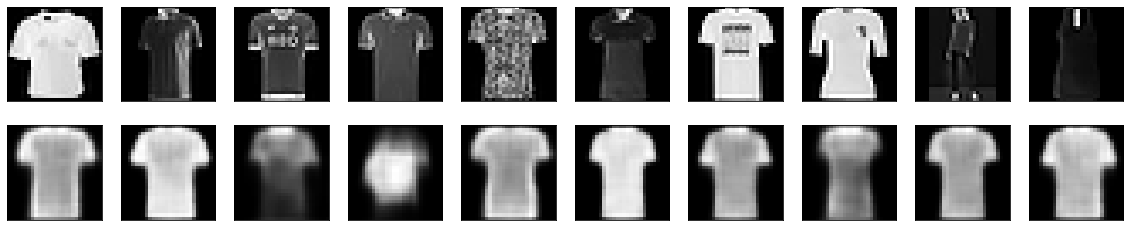

In [21]:
decoded_t_imgs = t_decoder.predict(encoded_t_imgs_train)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_t_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_t_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig(os.path.join("imgs", "t-conv-ae.png"))

## Reconstructed "7" (aka anomaly) with auto encoder

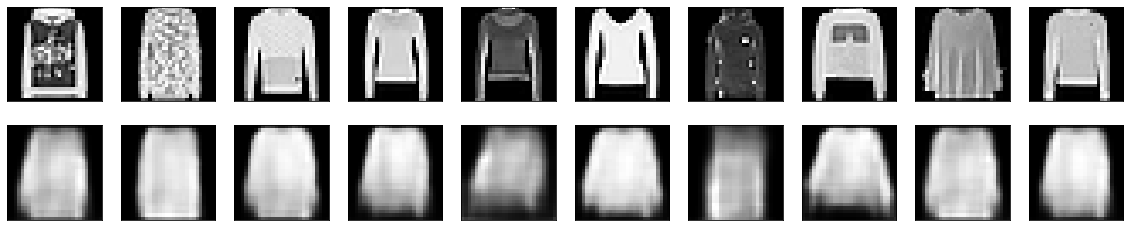

In [22]:
decoded_pullover_imgs = t_ae.predict(fashion_data[2][0])
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(fashion_data[2][0][i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_pullover_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig(os.path.join("imgs", "pullover-conv-t-ae.png"))

## Anomaly detection with root of squared loss per pixel

In [23]:
def loss_per_img(img,rec_img):
    return np.sqrt(np.sum(np.power(rec_img - img,2)))

In [67]:
pullover = fashion_data[2][0][:len(fashion_data[2][0])//100]
imgs = pullover.reshape(-1, 28, 28, 1)
rec_imgs = t_ae.predict(imgs)
pullover_losses = np.array([loss_per_img(i, ri) for i, ri in zip(imgs, rec_imgs)])

imgs = all_fashions#.reshape(-1,28,28,1)
rec_imgs = t_ae.predict(imgs)
all_fashions_losses = np.array([loss_per_img(i,ri) for i,ri in zip(imgs,rec_imgs)])

pullover_losses.max(), pullover_losses.mean()

(8.369027673380145, 5.338889565908909)

In [68]:
normal_losses = np.array([])
imgs = X_t_test.reshape(len(X_t_test),28,28,1)
rec_imgs = t_ae.predict(imgs)
normal_losses = np.array([loss_per_img(i,ri) for i,ri in zip(imgs,rec_imgs)])

normal_losses.max(), normal_losses.mean()

(8.660283743697207, 3.4533089263086896)

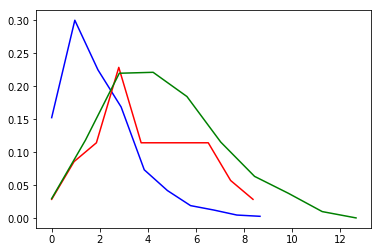

In [72]:
# loss distribution over the normal dataset
bins = 10
t = np.linspace(0, normal_losses.max(), bins)
hist_normal = np.histogram(normal_losses, bins=bins)
plt.plot(t, hist_normal[0] / len(normal_losses), "b")

# loss distribution over the anomaly dataset for fashion "pullover"
hist_pullovers = np.histogram(pullover_losses, bins=bins)
t = np.linspace(0, pullover_losses.max(), bins)
plt.plot(t, hist_pullovers[0] / len(pullover_losses), "r")

# loss distribution over the anomaly dataset for all fashions
hist_all = np.histogram(all_fashions_losses, bins=bins)
t = np.linspace(0, all_fashions_losses.max(), bins)
plt.plot(t, hist_all[0] / len(all_fashions_losses), "g")
plt.show()

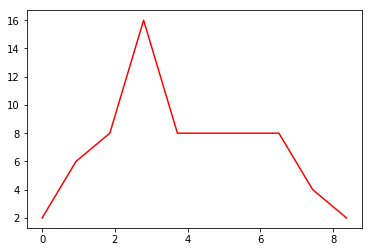

In [74]:
# loss distribution over the anomaly dataset
bins = 10
hist_anomaly = np.histogram(pullover_losses, bins=bins)
t = np.linspace(0, pullover_losses.max(), bins)
plt.plot(t, hist_anomaly[0], "r")
plt.show()

i:0.200, ratio:0.000, dn:0.800000 + ua:0.000000 = 0.800000
i:0.201, ratio:0.000, dn:0.799048 + ua:0.000000 = 0.799048
i:0.202, ratio:0.000, dn:0.798095 + ua:0.000000 = 0.798095
i:0.203, ratio:0.000, dn:0.797143 + ua:0.000000 = 0.797143
i:0.204, ratio:0.000, dn:0.796190 + ua:0.000000 = 0.796190
i:0.205, ratio:0.000, dn:0.795238 + ua:0.000000 = 0.795238
i:0.206, ratio:0.000, dn:0.794286 + ua:0.000000 = 0.794286
i:0.207, ratio:0.000, dn:0.793333 + ua:0.000000 = 0.793333
i:0.208, ratio:0.000, dn:0.792381 + ua:0.000000 = 0.792381
i:0.209, ratio:0.000, dn:0.791429 + ua:0.000000 = 0.791429
i:0.210, ratio:0.000, dn:0.790476 + ua:0.000000 = 0.790476
i:0.211, ratio:0.000, dn:0.789524 + ua:0.000000 = 0.789524
i:0.212, ratio:0.000, dn:0.788571 + ua:0.000000 = 0.788571
i:0.213, ratio:0.000, dn:0.787619 + ua:0.000000 = 0.787619
i:0.214, ratio:0.000, dn:0.786667 + ua:0.000000 = 0.786667
i:0.215, ratio:0.000, dn:0.785714 + ua:0.000000 = 0.785714
i:0.216, ratio:0.000, dn:0.784762 + ua:0.000000 = 0.7847

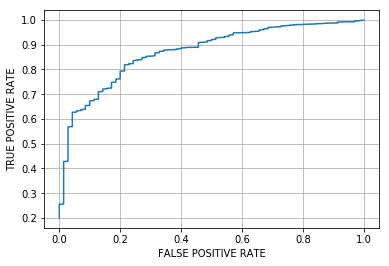

In [89]:
# x:= "false detected anomalies in %"
# y:= "correct detected normal data points in %"
rs = []
prec = 1000
step_size = 1 / prec
decs = np.arange(0.2, 1, step_size)
for i in decs:  # i == 0.95 seems to be a valid value
    loss_boundary = np.sort(normal_losses)[
        int(len(normal_losses) * i)
    ]  # loss value for detection of i% normal data points
    ind_undetected_anomalies = np.where(
        pullover_losses < loss_boundary
    )  # indices for undetected anomalies in the data set
    ind_detected_normals = np.where(
        normal_losses >= loss_boundary
    )  # indices for as anomaly detected normal data points in the data set
    detected_normals = X_t_test[ind_detected_normals]
    undetected_anomalies = fashion_data[2][0][ind_undetected_anomalies]

    ratio_of_undetected = len(undetected_anomalies) / len(
        pullover_losses
    )  # ratio between not detected loss values for anomalies
    rs = np.append(
        rs, [ratio_of_undetected]
    )
    if (int(i * prec)) % int(prec / 1000) == 0:
        print(
            "i:%.3f, ratio:%.3f, dn:%f + ua:%f = %f"
            % (
                i,
                ratio_of_undetected,
                len(detected_normals)/len(normal_losses),
                len(undetected_anomalies)/len(pullover_losses),
                len(detected_normals)/len(normal_losses) + len(undetected_anomalies)/len(pullover_losses),
            )
        )
plt.plot(rs, decs)  # ,zs=decs*rs)
plt.grid()
plt.xlabel("FALSE POSITIVE RATE")
plt.ylabel("TRUE POSITIVE RATE")
plt.show()

In [66]:
len(normal_losses), len(pullover_losses)

(1050, 700)

In [77]:
loss_boundary = np.sort(normal_losses)[int(len(normal_losses) * 0.810)]
ind_undetected_anomalies = np.where(
    pullover_losses < loss_boundary
)  # indices for undetected anomalies in the data set
ind_detected_normals = np.where(
    normal_losses >= loss_boundary
)  # indices for as anomaly detected normal data points in the data set

detected_normals = X_t_test[ind_detected_normals]
undetected_anomalies = fashion_data[2][0][ind_undetected_anomalies]
loss_boundary, len(detected_normals), len(undetected_anomalies)

(4.316599521080888, 200, 15)

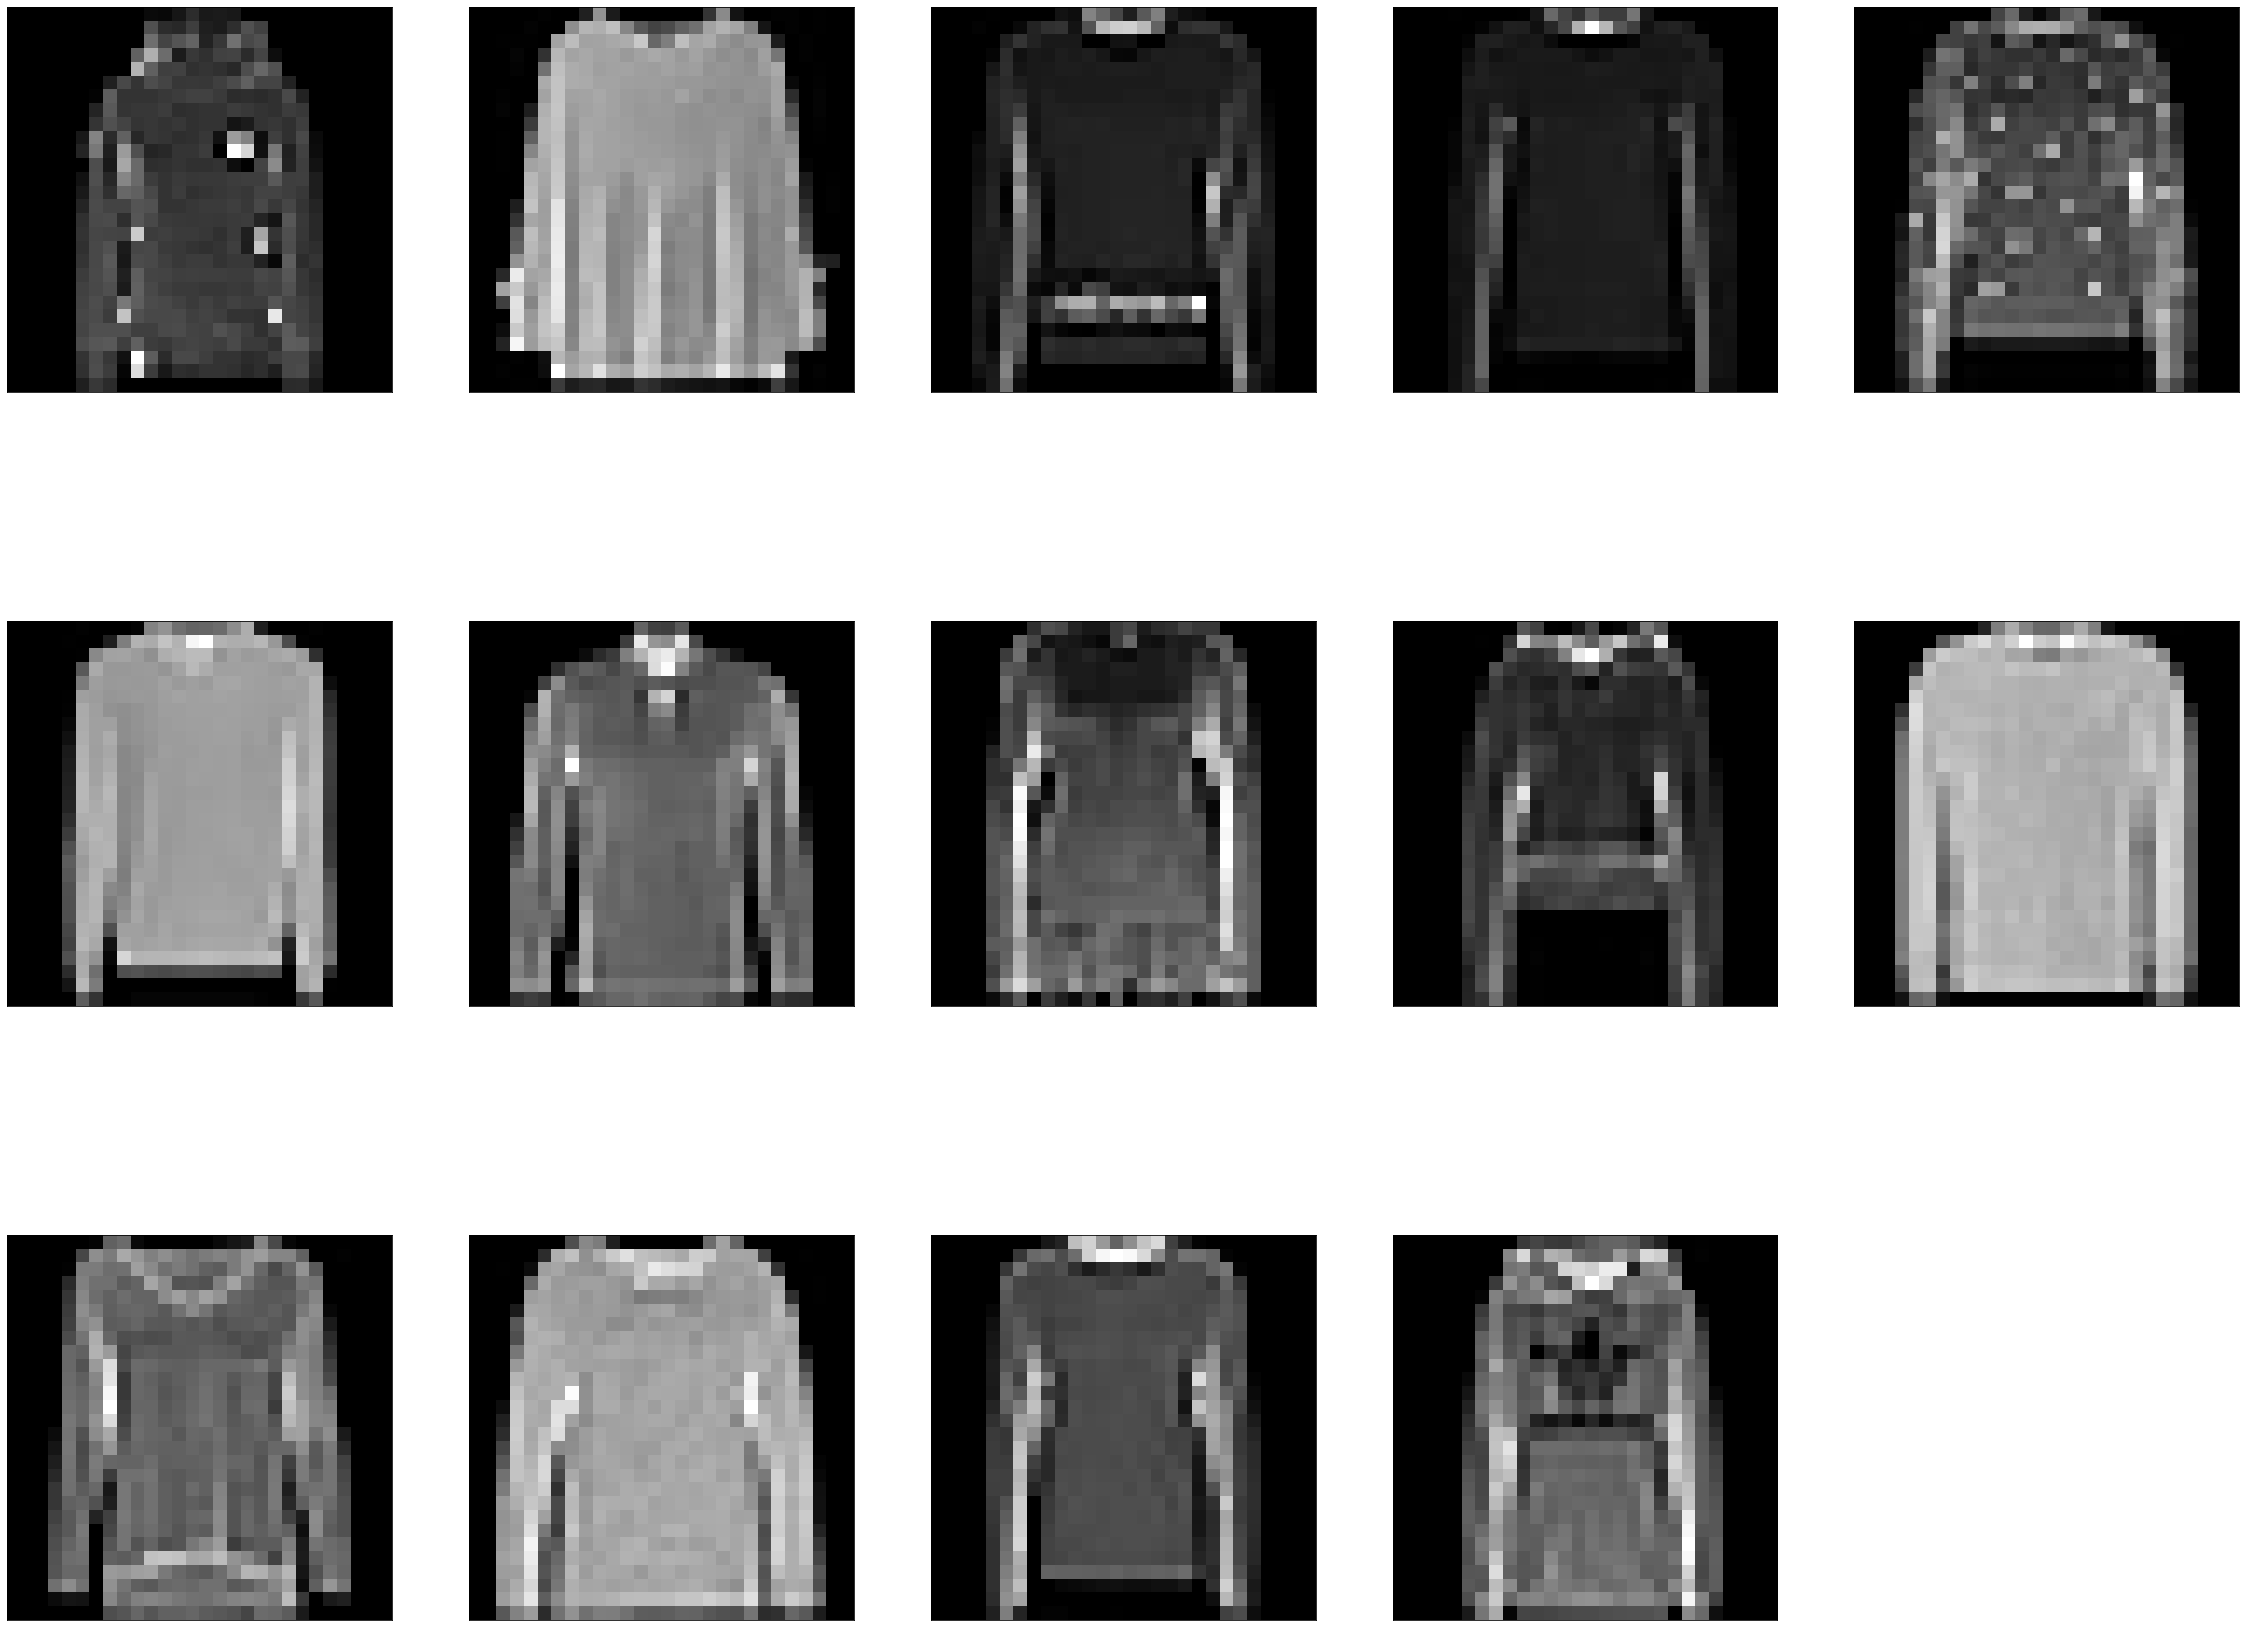

In [80]:
n = len(undetected_anomalies)  # how many digits we will display
plt.figure(figsize=(40, 32))
for i in range(n-1):
    ax = plt.subplot(n/5, n/3, i + 1)
    plt.imshow(undetected_anomalies[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig(os.path.join("imgs", "undetected-pullover.png"))

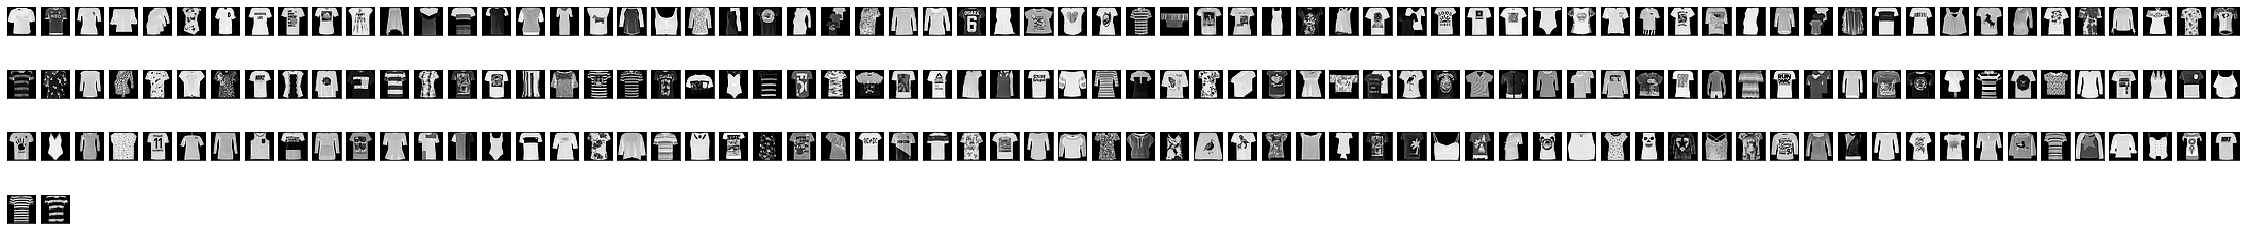

In [84]:
# display digits "1" which have been detectes as normaility 
n = len(detected_normals)  # how many digits we will display
plt.figure(figsize=(40, 32))
for i in range(n):
    ax = plt.subplot(n//7, n//3, i + 1)
    plt.imshow(detected_normals[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig(os.path.join("imgs", "detected-t-shirts.png"))

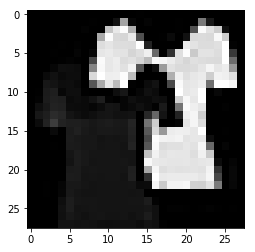

In [85]:
plt.imshow(X_t_test[np.argmax(normal_losses)].reshape((28,28)))
plt.show()

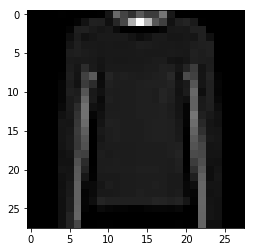

In [86]:
plt.imshow(fashion_data[2][0][np.argmin(pullover_losses)].reshape((28,28)))
plt.show()

# Anomaly Detector
This anomaly detector should be able to seperate images of the handwritten digits $1$ and $7$.

In [ ]:
def is_anomaly(ae, x):
    x = x.reshape((1,28,28,1))
    pred = ae.predict(x)
    loss = np.sum(pred - x) **2 # squared loss => positive value

## All digits classifier

In [ ]:
flat = np.prod(encoded_imgs_train.shape[1:], dtype=np.int64)
encoded_imgs_train = encoded_imgs_train.reshape(len(encoded_imgs_train), flat)
encoded_imgs_validate = encoded_imgs_validate.reshape(
    len(encoded_imgs_validate), flat)
encoded_imgs_test = encoded_imgs_test.reshape(len(encoded_imgs_test), flat)

In [ ]:
ckpt_loc = os.path.join(CUR_DIR, "ckpts", "classifier.hdf5")
if os.path.isfile(ckpt_loc):
    print("Loading classifier from directory %s..." % ckpt_loc)
    classifier = load_model(ckpt_loc)
else:
    print("Training classifier...")
    classifier = build_classifier(input_dim=flat)
    earlyStopping = EarlyStopping(
        monitor="val_acc", patience=5, verbose=1, mode="max", min_delta=0.0005
    )
    mcp_save = ModelCheckpoint(
        ckpt_loc, save_best_only=True, verbose=1, monitor="val_acc", mode="max"
    )
    reduce_lr_loss = ReduceLROnPlateau(
        monitor="val_acc", factor=0.3, patience=3, verbose=1, mode="max"
    )
    classifier.fit(
        encoded_imgs_train,
        y_train,
        validation_data=(encoded_imgs_validate, y_validate),
        batch_size=16,
        epochs=32,
        shuffle=True,
        callbacks=[earlyStopping, mcp_save, reduce_lr_loss],
    )

In [ ]:
eval_train = classifier.evaluate(encoded_imgs_train, y_train)
eval_validate = classifier.evaluate(encoded_imgs_validate, y_validate)
eval_test = classifier.evaluate(encoded_imgs_test, y_test)
eval_train,eval_validate, eval_test

In [ ]:
def get_cm(input, y_true):
    """Computes confusion matrix."""
    y_pred = tf.argmax(classifier.predict(input), axis=1)
    y_true = tf.argmax(y_true, axis=1)

    c = tf.keras.backend.eval(y_pred)
    d = tf.keras.backend.eval(y_true)

    return confusion_matrix(c, d)

In [ ]:
def precision(cm):
    results = []
    for i in range(len(cm)):  # rows
        TP = cm[i][i]
        fp_tp = np.sum(cm[i])
        results.append(TP / fp_tp)
    return results + [np.mean(results)]

In [ ]:
def recall(cm):
    results = []
    for i in range(len(cm)):  # rows
        TP = cm[i][i]
        tp_fn = 0
        for j in range(len(cm[i])):
            tp_fn += cm[j][i]
        results.append(TP/tp_fn)
    return results + [np.mean(results)]

In [ ]:
cm_train = get_cm(encoded_imgs_train, y_train)
print(cm_train, precision(cm_train)[-1], recall(cm_train)[-1], sep="\n")

cm_validate = get_cm(encoded_imgs_validate, y_validate)
print(cm_validate, precision(cm_validate)[-1], recall(cm_validate)[-1], sep="\n")

cm_test = get_cm(encoded_imgs_test, y_test)
print(cm_test, precision(cm_test)[-1], recall(cm_test)[-1], sep="\n")

# Anomaly Detection with DJ CF Gauss

In [ ]:
one_flat = np.prod(encoded_one_imgs_train.shape[1:], dtype=np.int64)
encoded_one_imgs_train = encoded_one_imgs_train.reshape(
    len(encoded_one_imgs_train), one_flat
)
encoded_one_imgs_validate = encoded_one_imgs_validate.reshape(
    len(encoded_one_imgs_validate), one_flat
)
encoded_one_imgs_test = encoded_one_imgs_test.reshape(
    len(encoded_one_imgs_test), one_flat
)

In [ ]:
def gauss(x_i, my_i, sigma_i2):
    # gaussian distribution for one feature
    if sigma_i2 == 0:
        return 1 if x_i == my_i else 0
    return np.array(
        (1 / np.sqrt(2 * np.pi * sigma_i2))
        * np.exp(-(x_i - my_i) ** 2 / (2 * sigma_i2))
    )

In [ ]:
def my(X):
    return np.array([(1 / len(x)) * np.sum(x) for x in X.T])

In [ ]:
def sigma2(X, my):
    # computes sigma squared for each feature
    m = len(X)  # number of data points
    return np.array([(1/m)*np.sum((X[:, i] - my[i]) ** 2) for i in range(len(my))])

In [ ]:
def p(X,my,sigma2):
    return np.array([np.prod([gauss(x[i], my[i], sigma2[i])
               for i in range(len(x))]) for x in X])

In [ ]:
X = encoded_one_imgs_train
m = len(X)
number_of_features = len(X[0])
my = np.array([(1 / len(x)) * np.sum(x) for x in X.T])
sigma_2 = np.array(
    [np.sum((X[:, i] - my[i]) ** 2) / m for i in range(number_of_features)]
)

p_all = np.sort(p(X, my, sigma_2))
epsilon = 1e-7
thresholded_P = p_all[np.where(p_all > epsilon)]
len(thresholded_P) / len(p_all), my, sigma_2

## Distribution of Encoded Features

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(len(my)):
    # plots distribution of i-th feature
    # display original
    bins = 51
    hist = np.histogram(X[:, i], bins=bins)
    ax = plt.subplot(4, 6, i + 1)
    h_min = min(hist[1])
    h_max = max(hist[1])
    delta = abs(h_max - h_min)
    step = delta / (bins)
    r = np.arange(h_min, h_max, step)
    plt.plot(r, hist[0])
    print(r, hist[0], step)

In [ ]:
def convert_values_to_img(values):
    values = np.reshape(values, (1, 2, 2, 6))
    random_img = decoder.predict(values)
    return np.reshape(random_img, (28, 28))

In [ ]:
bins = 50
hist_all = np.histogram(p_all, bins=bins)
h_min = min(hist_all[1])
h_max = max(hist_all[1])
delta = abs(h_max - h_min)
r = np.arange(h_min, h_max, delta / bins)
plt.plot(r, hist_all[0])

# Getting fashion-y

In [ ]:
def get_fashion():
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    img = X_train[0].reshape((28, 28))
    # reshape data to fit model
    plt.imshow(X_train[1], cmap="Greys", vmin=0, vmax=255)
    plt.savefig("fashion_example_img.png")

    """for Autoencoder"""
    X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
    X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
    # np.random.shuffle(X_test)
    X_validate = X_test[len(X_test) // 2 :]
    X_test = X_test[: len(X_test) // 2]

    return X_train / 255.0, X_test / 255.0, X_validate / 255.0

In [ ]:
X_fashion_train, X_fashion_test, X_fashion_validate = get_fashion()
print(X_fashion_test[:5])

# Colored images

In [ ]:
def unpickle(file):
    import pickle

    with open(file, "rb") as fo:
        dic = pickle.load(fo, encoding="bytes")
    return dic

In [ ]:
data_path = os.path.join(CUR_DIR, "data", "cifar-10-batches-py")
train_batches = []
test_batch = []
for filename in os.listdir(data_path):
    filename = os.path.join(data_path, filename)
    if "data_batch" in filename:
        train_batches.append(unpickle(filename))  # keys: labels, data, filenames
    if "test_batch" in filename:
        test_batch = unpickle(filename)
len(train_batches), test_batch

In [ ]:
data_path = os.path.join(CUR_DIR, "data", "cifar-100-python")
train_batches = []
test_batch = []
for filename in os.listdir(data_path):
    filename = os.path.join(data_path, filename)
    if "train" in filename:
        train_batches = unpickle(filename)  # keys: labels, data, filenames
    if "test" in filename:
        test_batch = unpickle(filename)
len(train_batches), test_batch